In [1]:
import re
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
IMAGES_PATH = os.path.join(os.getcwd(),'images')
IMAGE_SIZE = (200,200)

In [3]:
class Node:
    
    def __init__(self, name):
        self.node_name = name
        self.images = []
        self.children = []

    def add_image(self, image):
        self.images.append(image)

    def add_child(self, child):
        self.children.append(child)

    def print_tree(self, indent=0):
        result = "  " * indent + str(self.node_name) + "\n"
        
        # Print images in the current folder
        for image in self.images:
            result += "  " * (indent + 1) + f"[Image] {image}\n"
        
        # Recursively print children folders
        for child in self.children:
            result += child.print_tree(indent + 2)

        return result

    def __str__(self):
        return self.print_tree()

class Tree:
    
    def __init__(self, node):
        self.root = node

    def print_tree(self):
        print(str(self.root))


root = Node("images")

In [4]:
def build_tree_from_directory(path):
    def create_node_from_path(current_path):
        node = Node(os.path.basename(current_path))
        
        for item in os.listdir(current_path):
            item_path = os.path.join(current_path, item)
            
            if os.path.isdir(item_path):
                child_node = create_node_from_path(item_path)
                node.add_child(child_node)
            elif os.path.isfile(item_path) and item_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                node.add_image(item_path)
        
        return node
    
    root_node = create_node_from_path(path)
    return Tree(root_node)

def collect_images_and_labels(node, current_label=None):
    images = []
    labels = []
    
    if node.images:
        for image in node.images:
            images.append(image)
            labels.append(current_label)
    
    for child in node.children:
        child_label = child.node_name if current_label is None else f"{current_label}/{child.node_name}"
        child_images, child_labels = collect_images_and_labels(child, child_label)
        images.extend(child_images)
        labels.extend(child_labels)
    
    return images, labels

def create_feature_matrix(tree, image_size=(200, 200)):
    images, labels = collect_images_and_labels(tree.root)
    
    feature_matrix = []
    for image_path, label in zip(images, labels):
        img = cv2.imread(image_path)
        if img is not None:
            img_resized = cv2.resize(img, image_size)
            img_flattened = img_resized.flatten()
            feature_matrix.append(img_flattened)
    
    feature_matrix = np.array(feature_matrix)
    labels = np.array(labels)
    return feature_matrix, labels

def plot_image_from_features_vectir(vector, image_size=(200, 200)):
    img_reshaped = vector.reshape(image_size[0], image_size[1], 3)
    img_rgb = cv2.cvtColor(img_reshaped, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

def remove_suffix_from_label(label):
    return label.replace('/default', '').replace('/real_world', '')

In [5]:
root_image = build_tree_from_directory(IMAGES_PATH)

In [6]:
feature_matrix, labels = create_feature_matrix(root_image, IMAGE_SIZE)

In [7]:
labels = [remove_suffix_from_label(label) for label in labels]
labels = np.array(labels)

In [8]:
print(f'Shape of our features matrix is {feature_matrix.shape}')
print(f'Shape of our labels vector is {labels.shape}')

Shape of our features matrix is (15000, 120000)
Shape of our labels vector is (15000,)


In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
numeric_labels = le.fit_transform(labels)
label_mapping = {class_label: index for index, class_label in enumerate(le.classes_)}

In [10]:
X = feature_matrix.copy()
y = numeric_labels.copy()

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False)

# Create a new model that outputs the features from the last convolutional layer
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

# Function to preprocess and extract features from an image
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image to match VGG16 input size
    img_data = image.img_to_array(img)
    print(img_data.shape)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)  # Preprocess input according to VGG16 requirements
    
    features = model.predict(img_data)  # Extract features using the pre-trained model
    return features



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [ ]:

# Example usage
img_path = 'path/to/your/image.jpg'
features = extract_features(img_path)
print("Features shape:", features.shape)  # Example output shape: (1, 7, 7, 512)

### Applying Incremental PCA

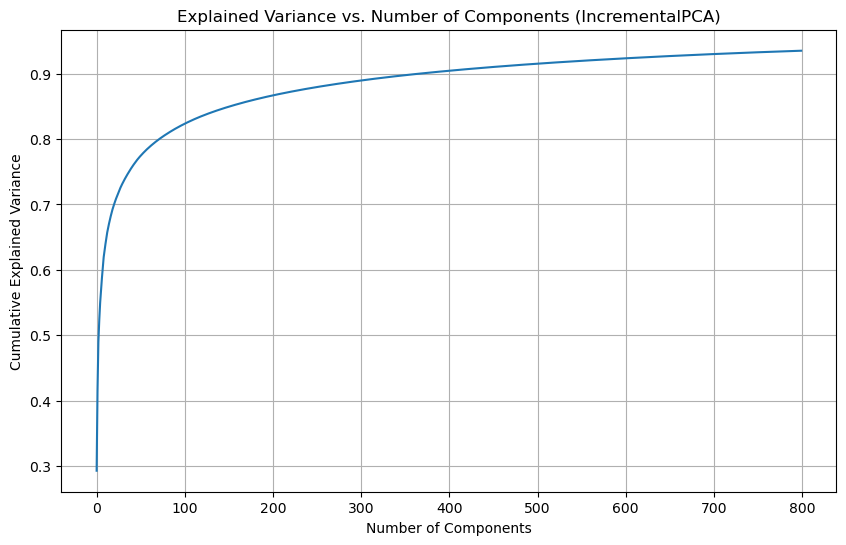

Number of components that explain 95.0% variance: 1


In [16]:
n_components = 800  # Choose a reasonable number of components initially
ipca = IncrementalPCA(n_components=n_components, batch_size=1000)

# Fit IncrementalPCA to your data
ipca.fit(X)

# Explained variance ratio
explained_variance_ratio = ipca.explained_variance_ratio_

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components (IncrementalPCA)')
plt.grid(True)
plt.show()

# Decide on the amount of variance to retain, e.g., 95%
target_variance = 0.95

# Find the number of components that explain the target variance
cumulative_variance = np.cumsum(explained_variance_ratio)
num_components = np.argmax(cumulative_variance >= target_variance) + 1

print(f'Number of components that explain {target_variance*100}% variance: {num_components}')

In [17]:
pca = PCA(n_components=900)
X_pca = pca.fit_transform(X)

In [20]:
strat_split  = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2) 
for train_index, test_index in strat_split.split(X_pca, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Verify the distribution of labels in the train and test sets
unique, train_counts = np.unique(y_train, return_counts=True)
unique, test_counts = np.unique(y_test, return_counts=True)
print("Train label distribution:", dict(zip(unique, train_counts)))
print("Test label distribution:", dict(zip(unique, test_counts)))

Train label distribution: {0: 400, 1: 400, 2: 400, 3: 400, 4: 400, 5: 400, 6: 400, 7: 400, 8: 400, 9: 400, 10: 400, 11: 400, 12: 400, 13: 400, 14: 400, 15: 400, 16: 400, 17: 400, 18: 400, 19: 400, 20: 400, 21: 400, 22: 400, 23: 400, 24: 400, 25: 400, 26: 400, 27: 400, 28: 400, 29: 400}
Test label distribution: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100, 10: 100, 11: 100, 12: 100, 13: 100, 14: 100, 15: 100, 16: 100, 17: 100, 18: 100, 19: 100, 20: 100, 21: 100, 22: 100, 23: 100, 24: 100, 25: 100, 26: 100, 27: 100, 28: 100, 29: 100}
